# Randomised Response for Mobility Data

This notebook explores how [Randomised Response](https://en.wikipedia.org/wiki/Randomized_response), a privacy preserving technique, can be applied to mobility data. Our intention is to show how simple privacy preserving techniques can be applied to a real problem - tracking the number of hired bikes passing through each
neighbourhood in a city.

We talk through this work in a series of blog posts:
* [How to measure representation in a data set and protect people’s privacy](https://www.projectsbyif.com/blog/how-to-measure-representation-in-a-data-set-and-protect-peoples-privacy/)
* [Equality in mobility matters now more than ever](https://www.projectsbyif.com/blog/equality-in-mobility-matters-now-more-than-ever/)

This exploration was funded through a grant from the [Benchmark Initiative](https://benchmarkinitiative.com/).

In [1]:
# We use citychef, from the Arup City Modelling Lab, to generate a synthetic city.
# At the time of writing, it does not have a prebuilt pip package, but can be
# downloaded from: https://github.com/fredshone/citychef
from citychef import spatial
from citychef import graph
from citychef import osm
from citychef import tree
from shapely.geometry import Point, MultiPoint, LineString
from shapely.ops import nearest_points

import math
import pandas as pd
import geopandas as gpd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

# Explicitly set a random seed, so that the example images we generate stay
# the same between notebook runs.
random.seed(42)
np.random.seed(42)

## Simulated data

### Households, work places and streets

We use [City Chef](https://github.com/fredshone/citychef) from the [Arup City Modelling Lab](https://medium.com/arupcitymodelling) to generate a synthetic city. We generate clusters of
households and workplaces, and a street network connecting them, followed by neighbourhoods
of roughly equal numbers of households.

In [2]:
def BuildNetwork(box):
    """Generate clustered households and workplaces and a street network between them."""
    centers = spatial.Centres(box, density=1)
    facilities = {
        "households": spatial.Clusters(centers, size=10000, sigma=.3),
        "workplaces": spatial.Clusters(centers, size=500, sigma=.3),
    }
    box = spatial.collect_bbox(facilities)
    network = graph.TreeNetwork(box, facilities["households"], grid="regular", max_points=200)
    return box, centers, facilities, network

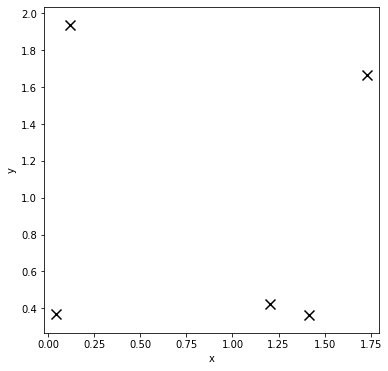

In [3]:
box = np.array([[0.0, 0.0], [2.0, 2.0]])
box, centers, facilities, network = BuildNetwork(box)
centers.plot()

**Centers of clusters of households and workplaces**

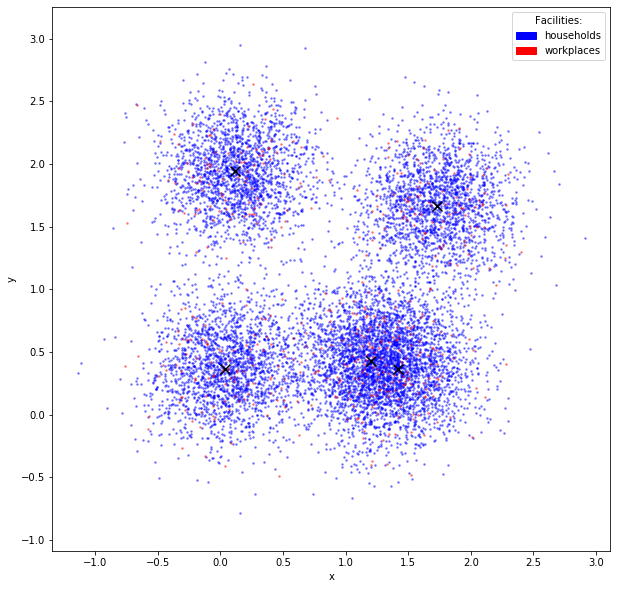

In [4]:
spatial.plot_facilities(facilities, centres=centers)

**The households and workplaces clustered around the centers shown in the previous figure**

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


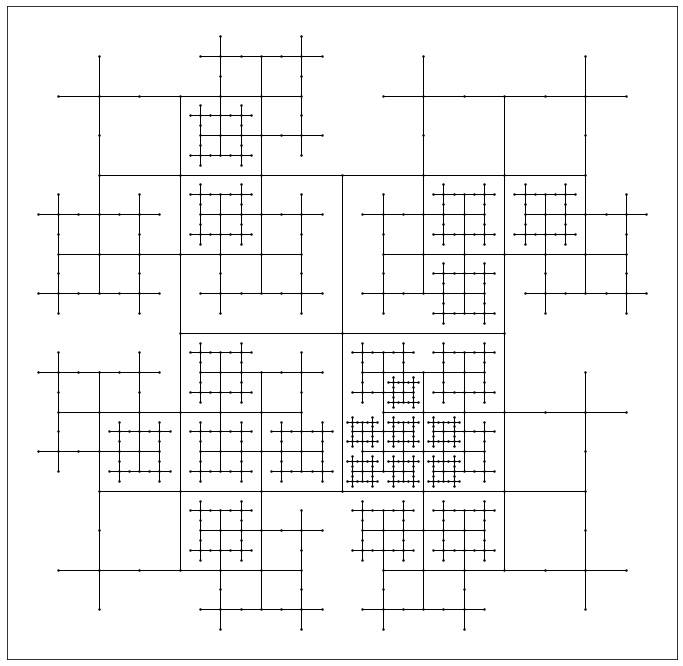

In [5]:
network.plot()

**The street network connecting our clustered households and workplaces**

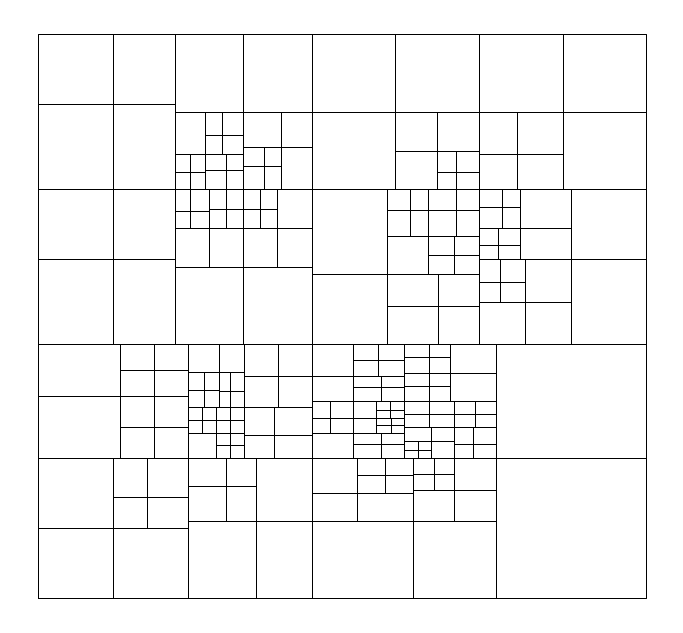

In [6]:
zones = tree.Zones(box, facilities["households"], max_zone_facilities=100, max_sub_zone_facilities=100)
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.set_axis_off()
zones.zone_gdf.geometry.boundary.plot(ax=ax, color=None, edgecolor="black", linewidth=1)

**The boundaries of neighbourhoods partitioning our city**

### Bike trips

We pick one thousand random home and workplace locations, and find the shortest path
between them through the street network. These paths become our simulated bike trips.

In [7]:
class NearestNodes:
    """Build a shapely MultiPoint instance for the nodes of a street network graph.
       Use the MultiPoint instance to find the nearest node in the graph to an
       arbitrary spatial point. Not computationally efficient, but simple, and
       good enough for our example.
    """
    
    def __init__(self, graph):
        self.by_pos = {v["pos"]: k for k, v in graph.nodes.items()}
        self.points = MultiPoint([v["pos"] for k, v in graph.nodes.items()])
        
    def Nearest(self, point):
        """Return the nearest node to the given shapely point."""
        nearest_point = nearest_points(self.points, point)[0]
        return self.by_pos[(nearest_point.x, nearest_point.y)]
    
nearest = NearestNodes(network.g)

In [8]:
NUMBER_OF_BIKES = 1000

def AddLengthAttributes(graph):
    """Add a 'length' attribute to each graph edge with the edge's physical length."""
    for edge in graph.edges:
        points = [Point(*graph.nodes[node]["pos"]) for node in edge]
        graph.edges[edge]["length"] = points[0].distance(points[1])

def GenerateTrips(facilities, network):
    households = facilities["households"]
    bikes = [Point(x, y) for (x, y) in random.choices(list(zip(households.x, households.y)), k=NUMBER_OF_BIKES)]
    destinations = [Point(x, y) for (x, y) in zip(facilities["workplaces"].x, facilities["workplaces"].y)]
    paths = []
    for bike in bikes:
        start = nearest.Nearest(bike)
        end = nearest.Nearest(random.choice(destinations))
        paths.append(nx.shortest_path(network.g, start, end, weight="length"))
    return paths

AddLengthAttributes(network.g)
paths = GenerateTrips(facilities, network)

In [9]:
def MapPathsToNeighbourhoods(paths, neighbourhoods):
    """Map a list of paths to lists of neighbourhoods that each path traverses."""
    path_neighbourhoods = []
    locations = {node: items["pos"] for (node, items) in network.g.nodes.items()}
    for path in paths:
        traversed = set()
        for (area_id, geometry) in zip(neighbourhoods.area_id, neighbourhoods.geometry):
            for i in range(0, len(path) - 1):
                line = LineString([locations[node] for node in (path[i], path[i+1])])
                if line.intersects(geometry):
                    traversed.add(area_id)
        path_neighbourhoods.append(traversed)
    return path_neighbourhoods

path_neighbourhoods = MapPathsToNeighbourhoods(paths, zones.zone_gdf)

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


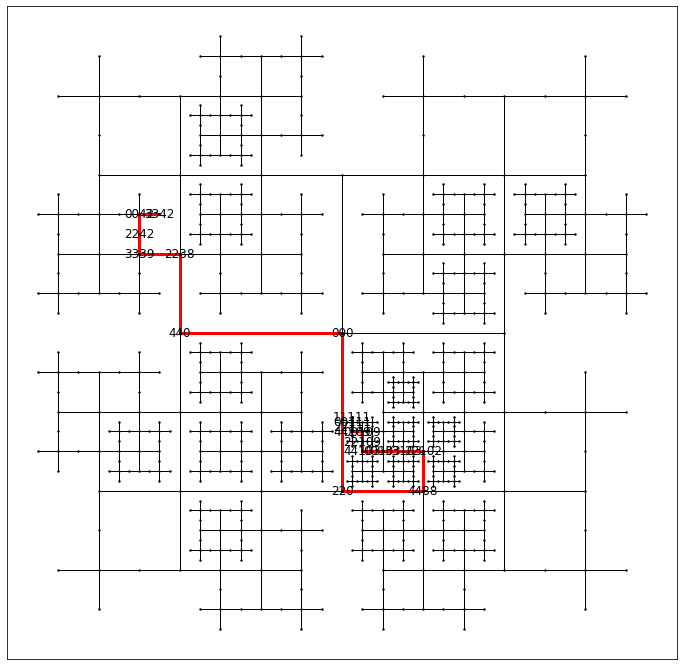

In [10]:
def MakeSubgraphFromPath(graph, path):
    """Return the subgraph of 'graph' that's traversed by the list of nodes 'path'.
       Used to render the path of a bike on top of the full street network.
    """
    subgraph = nx.Graph()
    for node in path:
        subgraph.add_node(node, **graph.nodes[node])
    for i in range(0, len(path)-1):
        subgraph.add_edge(path[i], path[i+1])
    return subgraph

PATH_TO_SHOW = 0

subgraph = MakeSubgraphFromPath(network.g, paths[PATH_TO_SHOW])
pos = {k: v["pos"] for k,v in subgraph.nodes.items()}

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
network.plot(ax=ax)
nx.draw_networkx(subgraph, pos=pos, ax=ax, edge_color="red", width=3, node_color="black", node_size=4)

**The path taken by one bike through the street network**

## Applying randomised response to protect trip data
### Protecting individual trips

For each trip taken by a bike, we apply randomised response to the list of neigbourhoods traversed by that bike. For each neighbourhood, we flip a coin. If the coin show heads, we say that the bike traversed that area, regardless of whether or not it did. If the coin shows tails, we answer truthfully.

In [11]:
HEADS = 0
TAILS = 1

def Protect(all_neighbourhoods, neighbourhoods_traversed):
    protected = []
    for neighbourhood in all_neighbourhoods:
        if random.choice([HEADS, TAILS]) == HEADS: # Always say yes
            protected.append(neighbourhood)
        elif neighbourhood in neighbourhoods_traversed: # Answer truthfully
            protected.append(neighbourhood)
    return protected

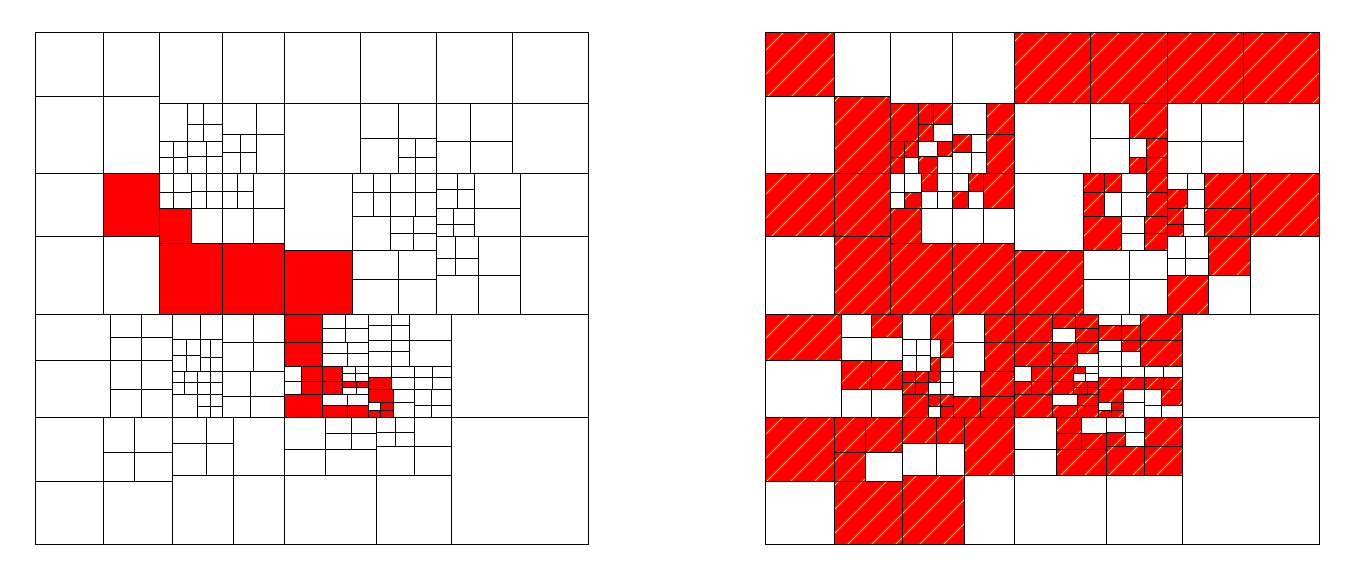

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(24, 12))
for ax in axs:
    ax.set_axis_off()
    zones.zone_gdf.geometry.boundary.plot(ax=ax, color=None, edgecolor="black", linewidth=1)
neighbourhoods_traversed = zones.zone_gdf[zones.zone_gdf.area_id.isin(path_neighbourhoods[PATH_TO_SHOW])]
neighbourhoods_traversed.geometry.plot(ax=axs[0], facecolor="red", linewidth=1)
neighbourhoods_protected = zones.zone_gdf[zones.zone_gdf.area_id.isin(Protect(zones.zone_gdf.area_id, path_neighbourhoods[PATH_TO_SHOW]))]
neighbourhoods_protected.geometry.plot(ax=axs[1], edgecolor="yellow", facecolor="red", linewidth=1, hatch="/")

**On the left, the actual areas traversed by a bike. On the right, the areas we show as being traversed having applied randomised response**

### Computing metrics from protected trips
In the protected data, we expect that half of the bikes will say they traversed a given neighbourhood because of the coin toss, independently of whether they actually did. The true number of bikes who did not traverse a neighbourhood is, therefore, approximately twice the number of bikes who reported they did not traverse the neighbourhood. Using this result, we can estimate the number of bikes passing through each neighbourhood from the protected data, without knowing which bikes realling did traverse it.

In [13]:
def EstimateBikesTraversing(protected_count):
    protected_not_traversing = NUMBER_OF_BIKES - protected_count
    return max(NUMBER_OF_BIKES - (2 * protected_not_traversing), 0)

exact_counts = {}
for neighbourhoods in path_neighbourhoods:
    for neighbourhood in neighbourhoods:
        exact_counts[neighbourhood] = exact_counts.get(neighbourhood, 0) + 1

protected_counts = {}
protected_path_neighbourhoods = [Protect(zones.zone_gdf.area_id, path_neighbourhood) for path_neighbourhood in path_neighbourhoods]
for protected_neighbourhoods in protected_path_neighbourhoods:
    for neighbourhood in protected_neighbourhoods:
        protected_counts[neighbourhood] = protected_counts.get(neighbourhood, 0) + 1
estimated_counts = {k: EstimateBikesTraversing(v) for k, v in protected_counts.items()}


In [14]:
both_counts = pd.DataFrame(
    data=[[exact_counts.get(neighbourhood, 0), estimated_counts.get(neighbourhood, 0)] for neighbourhood in zones.zone_gdf.area_id],
    columns=("exact_counts", "estimated_counts"),
    index=zones.zone_gdf.area_id)

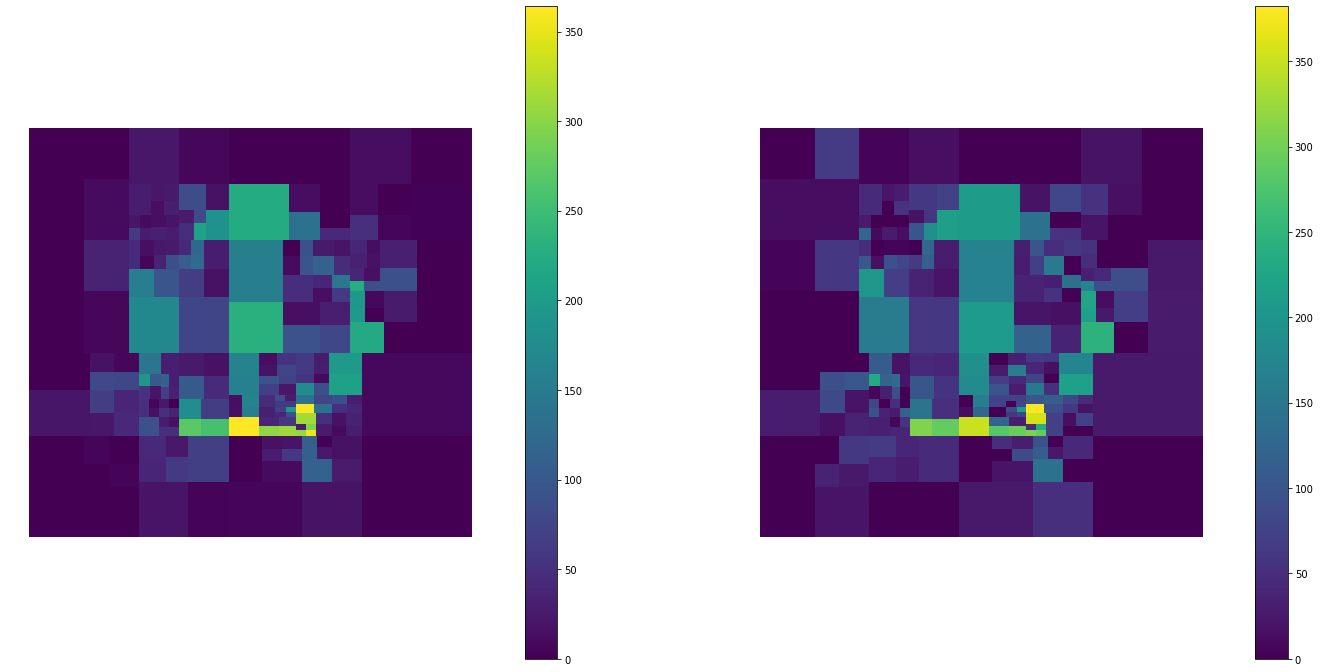

In [15]:
both_counts["geometry"] = zones.zone_gdf.geometry
with_geometry = gpd.GeoDataFrame(both_counts.assign(geometry=zones.zone_gdf.geometry), geometry="geometry")
fig, axs = plt.subplots(1, 2, figsize=(24, 12))
for ax in axs:
    ax.set_axis_off()
with_geometry.plot(column="exact_counts", ax=axs[0], legend=True)
with_geometry.plot(column="estimated_counts", ax=axs[1], legend=True)

**On the left, a heatmap of the actual number bikes traversing each neighbourhood. On the right, a heatmap of the estimated number of bikes traversing each neighbourhood based on the protected data.**

### Protecting privacy by adding noise
One was of looking at randomised response is that it protects privacy by adding noise to data. Differential privacy takes the concept further, providing a rigourous mathematical underpinning to providing a level of privacy against attackers with access to arbitrary additional datasets.

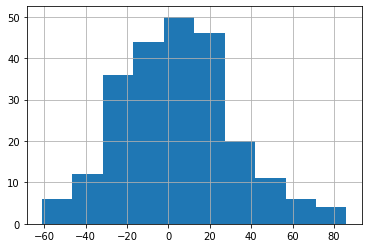

In [16]:
(both_counts.estimated_counts - both_counts.exact_counts).hist()

**The distribution of error in our estimates from protected trip data, when compared against the actual trip data.**

Copyright 2020 Projects by IF

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.